In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sma

In [2]:
df = pd.read_csv("CleanedData.csv")
df = df[df["Price"] > 0]
df = df[df['Pre2005Flag']!=1]

In [3]:
#df['Pre2005Flag'].value_counts()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1381 entries, 0 to 1642
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Company                 1381 non-null   object 
 1   Price                   1381 non-null   float64
 2   PriceStartDate          1381 non-null   object 
 3   Date Added              1381 non-null   object 
 4   InflationAdjustedPrice  1381 non-null   float64
 5   Analysis                1352 non-null   object 
 6   P or E                  1381 non-null   object 
 7   Pre2005Flag             1381 non-null   int64  
 8   PreviousPatents         1381 non-null   int64  
 9   LatestExpiration        1381 non-null   object 
 10  MonthsUntilExpiration   1381 non-null   float64
 11  PriceDelta              1381 non-null   float64
 12  PercentageE             1381 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 151.0+ KB


In [5]:
mean = df['InflationAdjustedPrice'].mean()
std =df['InflationAdjustedPrice'].std()
df['InflationAdjustedPriceZScore'] = (df['InflationAdjustedPrice'] - mean)/std
df= df[(df['InflationAdjustedPriceZScore'] <=3)&(df['InflationAdjustedPriceZScore'] >=-3)]

In [6]:
df['P or E'].value_counts(normalize=True)

P    0.814675
E    0.185325
Name: P or E, dtype: float64

Assigning binary dependent variable from the Analysis variable. The following categories will be classified as suspected evergreen:
- P:PED
- PTAorPTE
- DlistRequest
- NPP
- PED
- P-PEDExtension
- UCsamemonth
- DP
- DS/DP
- DS/DP/UCnew
- DP/UCnew
- DS

In [7]:
df['EvergreenFlag'] = [0] * len(df)
df.loc[df['P or E']=='E','EvergreenFlag'] = 1

In [8]:
df['EvergreenFlag'].value_counts(normalize=True)

0    0.814675
1    0.185325
Name: EvergreenFlag, dtype: float64

In [9]:
model_df = df[['MonthsUntilExpiration',
              'PreviousPatents','EvergreenFlag',
              'PercentageE','PriceDelta']]
#model_df['Initial Filing'] = [0] * len(model_df)
#model_df.loc[model_df['PreviousPatents']==0,'Initial Filing'] = 1

In [10]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 0 to 1642
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MonthsUntilExpiration  1322 non-null   float64
 1   PreviousPatents        1322 non-null   int64  
 2   EvergreenFlag          1322 non-null   int64  
 3   PercentageE            1322 non-null   float64
 4   PriceDelta             1322 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 62.0 KB


In [11]:
def ZStandardize(array):
    mean = array.mean()
    std = array.std()
    new_array = (array - mean)/std
    return(new_array)

In [12]:
for column in model_df.drop(columns='EvergreenFlag').columns:
    model_df[column] = ZStandardize(model_df[column])

C:\Users\sulli\AppData\Local\Temp\ipykernel_17180\770102775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[column] = ZStandardize(model_df[column])


In [13]:
model_df.describe()

,MonthsUntilExpiration,PreviousPatents,EvergreenFlag,PercentageE,PriceDelta
count,1.322000e+03,1.322000e+03,1322.000000,1.322000e+03,1.322000e+03
mean,-3.486873e-16,2.343058e-16,0.185325,2.864577e-15,1.943058e-15
std,1.000000e+00,1.000000e+00,0.388708,1.000000e+00,1.000000e+00
min,-2.531948e+00,-7.714763e-01,0.000000,-9.315762e-01,-3.187632e+00
25%,-7.449981e-01,-7.288369e-01,0.000000,-9.315762e-01,9.259197e-02
50%,1.782595e-01,-3.877217e-01,0.000000,1.155257e-01,3.084138e-01
75%,9.029670e-01,3.797873e-01,0.000000,5.457801e-01,3.813168e-01
max,1.816297e+00,4.302612e+00,1.000000,7.139834e+00,7.047727e+00


In [14]:
model_df['EvergreenFlag'].value_counts(normalize=True)

0    0.814675
1    0.185325
Name: EvergreenFlag, dtype: float64

In [15]:
model_df = sma.add_constant(model_df)
clf = sma.Logit(model_df['EvergreenFlag'],model_df.drop(columns='EvergreenFlag')).fit()
print(clf.summary())

Optimization terminated successfully.
         Current function value: 0.454433
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          EvergreenFlag   No. Observations:                 1322
Model:                          Logit   Df Residuals:                     1317
Method:                           MLE   Df Model:                            4
Date:                Thu, 06 Apr 2023   Pseudo R-squ.:                 0.05203
Time:                        10:00:59   Log-Likelihood:                -600.76
converged:                       True   LL-Null:                       -633.73
Covariance Type:            nonrobust   LLR p-value:                 1.629e-13
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5718      0.076    -20.693      0.000      -1.721      -1.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [18]:
X_train, X_test, y_train, y_test = train_test_split(model_df.drop(columns='EvergreenFlag'),
                                                   model_df['EvergreenFlag'],test_size=.25,
                                                   random_state = 1)

In [19]:
y_train.sum()/(len(y_train))

0.18163471241170534

In [20]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                         save=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    if save:
        plt.savefig(save)
        plt.show()

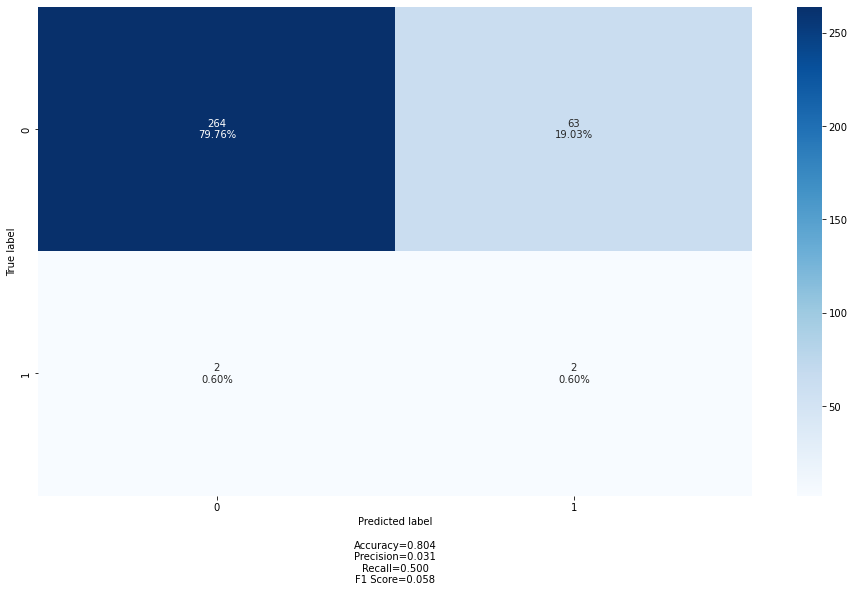

In [21]:
clf = LogisticRegression().fit(X_train,y_train)
predictions = clf.predict(X_test)
make_confusion_matrix(confusion_matrix(predictions,y_test),
                     figsize=(16,9))

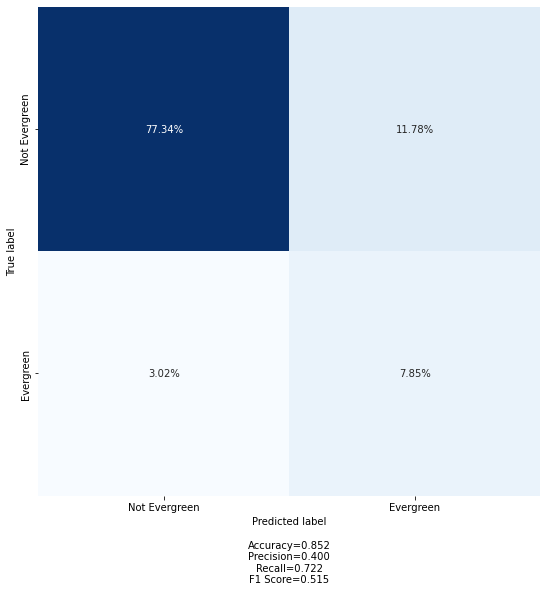

In [27]:
clf = DecisionTreeClassifier().fit(X_train,y_train)
predictions = clf.predict(X_test)
make_confusion_matrix(confusion_matrix(predictions,y_test),
                     figsize=(9,9),
                     save='ConfusionMatrix.png',count=False,
                     categories=['Not Evergreen','Evergreen'],
                     cbar=False)

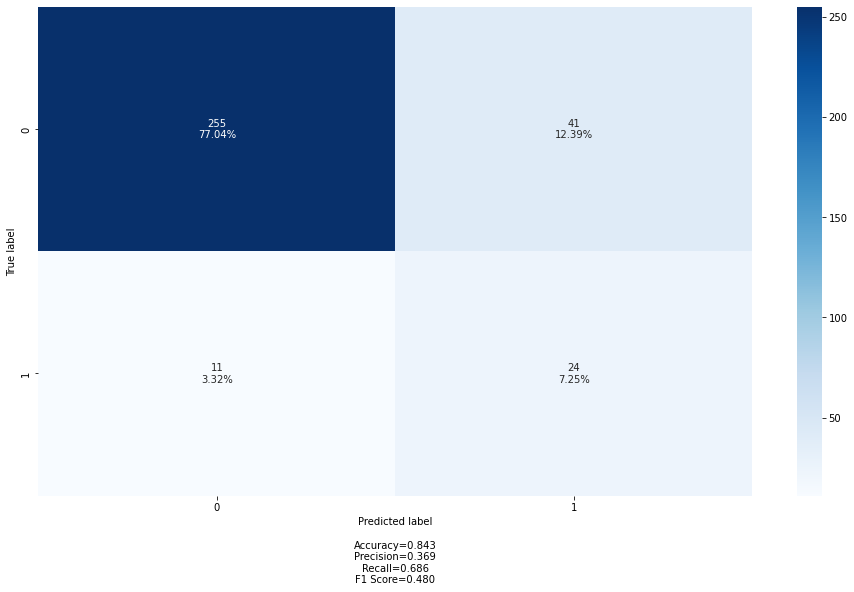

In [23]:
clf = RandomForestClassifier().fit(X_train,y_train)
predictions = clf.predict(X_test)
make_confusion_matrix(confusion_matrix(predictions,y_test),
                     figsize=(16,9))

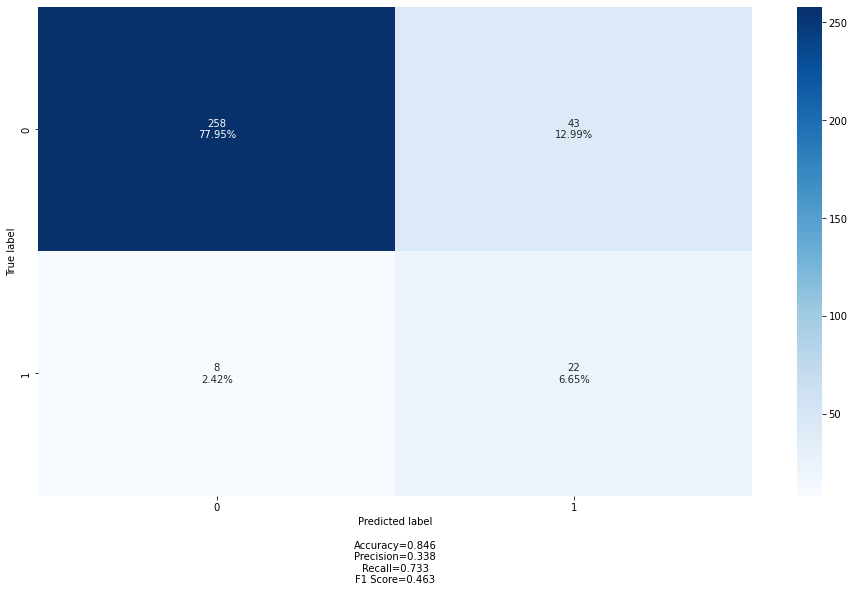

In [24]:
clf = GradientBoostingClassifier().fit(X_train,y_train)
predictions = clf.predict(X_test)
make_confusion_matrix(confusion_matrix(predictions,y_test),
                     figsize=(16,9))

In [25]:
X_train = sma.add_constant(X_train)
X_test = sma.add_constant(X_test)
clf = sma.Logit(y_train,X_train).fit()
print(clf.summary())

Optimization terminated successfully.
         Current function value: 0.453101
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          EvergreenFlag   No. Observations:                  991
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                            4
Date:                Thu, 06 Apr 2023   Pseudo R-squ.:                 0.04382
Time:                        10:01:00   Log-Likelihood:                -449.02
converged:                       True   LL-Null:                       -469.60
Covariance Type:            nonrobust   LLR p-value:                 2.501e-08
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.5912      0.088    -18.071      0.000      -1.764      -1.